In [1]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

In [3]:
!unzip /content/img_cls_scenes_classification.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/scenes_classification/train/mountain/16162.jpg  
  inflating: /content/scenes_classification/train/mountain/16173.jpg  
  inflating: /content/scenes_classification/train/mountain/16225.jpg  
  inflating: /content/scenes_classification/train/mountain/16322.jpg  
  inflating: /content/scenes_classification/train/mountain/16341.jpg  
  inflating: /content/scenes_classification/train/mountain/16350.jpg  
  inflating: /content/scenes_classification/train/mountain/16374.jpg  
  inflating: /content/scenes_classification/train/mountain/16375.jpg  
  inflating: /content/scenes_classification/train/mountain/16417.jpg  
  inflating: /content/scenes_classification/train/mountain/1642.jpg  
  inflating: /content/scenes_classification/train/mountain/16421.jpg  
  inflating: /content/scenes_classification/train/mountain/16438.jpg  
  inflating: /content/scenes_classification/train/mountain/16560.jpg  
  inflating: /content/scene

In [4]:
root_dir = 'scenes_classification'
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'val')

classes = {
    label_idx: class_name
    for label_idx, class_name in enumerate(sorted(os.listdir(train_dir)))
}

In [5]:
X_train = []
y_train = []
X_test = []
y_test = []

for dataset_path in [train_dir, test_dir]:
    for label_idx, class_name in classes.items():
        class_dir = os.path.join(dataset_path, class_name)
        for img_filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_filename)
            if 'train' in dataset_path:
                X_train.append(img_path)
                y_train.append(label_idx)
            else:
                X_test.append(img_path)
                y_test.append(label_idx)

In [6]:
seed = 0
val_size = 0.2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

In [7]:
from torch.utils.data import Dataset
from PIL import Image

class ScenesDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.img_paths = X
        self.labels = y

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]

In [8]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)[..., :3]
    img = torch.tensor(img).permute(2, 0, 1).float()
    normalized_img = img / 255.0

    return normalized_img

In [9]:
train_dataset = ScenesDataset(
    X_train, y_train,
    transform=transform
)
val_dataset = ScenesDataset(
    X_val, y_val,
    transform=transform
)
test_dataset = ScenesDataset(
    X_test, y_test,
    transform=transform
)

In [10]:
train_batch_size = 64
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

In [11]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(BottleneckBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        res = x.clone().detach()
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = torch.cat([res, x], 1)

        return x

In [12]:
class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(BottleneckBlock(in_channels + i * growth_rate, growth_rate))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [13]:
class DenseNet(nn.Module):
    def __init__(self, num_blocks, growth_rate, num_classes):
        super(DenseNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 2 * growth_rate, kernel_size=7, padding=3, stride=2, bias=False)
        self.bn1 = nn.BatchNorm2d(2 * growth_rate)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.dense_blocks = nn.ModuleList()
        in_channels = 2 * growth_rate
        for i, num_layers in enumerate(num_blocks):
            self.dense_blocks.append(DenseBlock(num_layers, in_channels, growth_rate))
            in_channels += num_layers * growth_rate
            if i != len(num_blocks) - 1:
                out_channels = in_channels // 2
                self.dense_blocks.append(nn.Sequential(
                    nn.BatchNorm2d(in_channels),
                    nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                    nn.AvgPool2d(kernel_size=2, stride=2)
                ))
                in_channels = out_channels

        self.bn2 = nn.BatchNorm2d(in_channels)
        self.pool2 = nn.AvgPool2d(kernel_size=7)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)

        for block in self.dense_blocks:
            x = block(x)

        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [14]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = DenseNet(
    [6, 12, 24, 16],
    growth_rate=32,
    num_classes=n_classes
).to(device)

In [15]:
lr = 1e-2
epochs = 15

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr
)

In [16]:
def evaluate(model, dataloader, criterion, device):
  model.eval()
  correct = 0
  total = 0
  losses = []
  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      losses.append(loss.item())

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    accuracy = correct / total

    return loss, accuracy

In [17]:
def fit(model, train_loader, val_loader, criterion, optimizer, epochs, device):
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
    train_batch_losses = []
    model.train()

    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      train_batch_losses.append(loss.item())

      loss.backward()
      optimizer.step()

    train_loss = sum(train_batch_losses) / len(train_batch_losses)
    train_losses.append(train_loss)

    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)

    print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

  return train_losses, val_losses

In [18]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs,
    device
)

EPOCH 1:	Train loss: 1.6820	Val loss: 1.8351
EPOCH 2:	Train loss: 1.5760	Val loss: 1.4041
EPOCH 3:	Train loss: 1.2886	Val loss: 1.3474
EPOCH 4:	Train loss: 1.2596	Val loss: 1.4514
EPOCH 5:	Train loss: 1.3442	Val loss: 1.3953
EPOCH 6:	Train loss: 1.3166	Val loss: 1.4799
EPOCH 7:	Train loss: 1.2192	Val loss: 1.3019
EPOCH 8:	Train loss: 1.1357	Val loss: 1.2411
EPOCH 9:	Train loss: 1.1678	Val loss: 1.4368
EPOCH 10:	Train loss: 1.1971	Val loss: 1.2944
EPOCH 11:	Train loss: 1.2284	Val loss: 1.5110
EPOCH 12:	Train loss: 1.3304	Val loss: 1.4548
EPOCH 13:	Train loss: 1.3235	Val loss: 1.3535
EPOCH 14:	Train loss: 1.2626	Val loss: 1.4646
EPOCH 15:	Train loss: 1.2363	Val loss: 1.3492


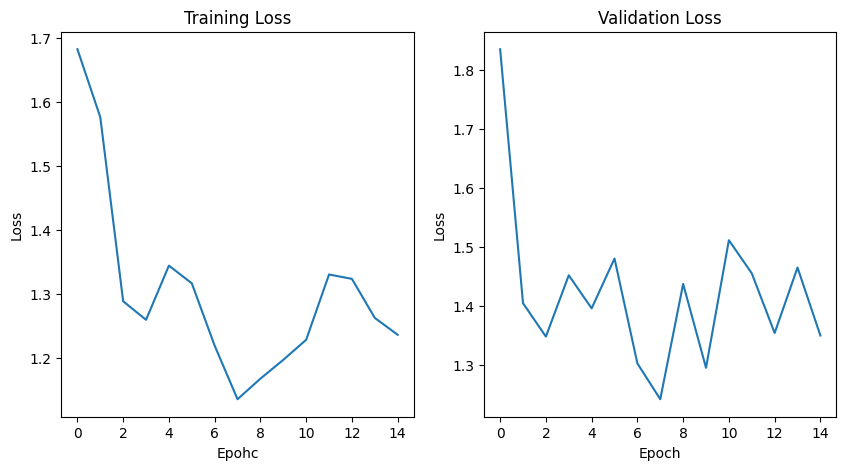

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(train_losses)
ax[0].set(xlabel='Epohc', ylabel='Loss')
ax[0].set_title('Training Loss')

ax[1].plot(val_losses)
ax[1].set(xlabel='Epoch', ylabel='Loss')
ax[1].set_title('Validation Loss')

plt.show()

In [20]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)

test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy:', val_acc)
print('Test accuracy:', test_acc)

Evaluation on val/test dataset
Val accuracy: 0.5415033843961524
Test accuracy: 0.533
